# Part 2a: Transient behaviour and current dependency

In [31]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.interpolate import interp2d
from scipy.optimize import curve_fit

try:  # if running with Google Colab
    from google.colab import drive
    drive.mount('/content/drive')

    import sys
    # the location where you saved the tools.py and csv files
    drive_dir = '/content/drive/My Drive/Colab Notebooks/FCTT 3'
    sys.path.insert(0, drive_dir)

    data_dir = os.path.join(drive_dir, 'battery_experimental_data')
    fit_res_dir = os.path.join(drive_dir, 'fitting_results')
except:  # if running locally
    data_dir = os.path.abspath('battery_experimental_data')
    fit_res_dir = os.path.abspath('fitting_results')
    
from tools import *

## Load data

In [32]:
training_data_20 = pd.read_csv(os.path.join(data_dir, 'Model_Training_Data_20.csv'))
SOC_OCV_data = pd.read_csv(os.path.join(data_dir, 'SOC_OCV_MFCTT_2019.csv'), sep='\t')

display(training_data_20.head())

,Time (s),Current (A),Voltage (V)
0,0.000000,0.0,4.2
1,1.000005,0.0,4.2
2,1.999999,0.0,4.2
3,3.000004,0.0,4.2
4,3.999998,0.0,4.2


In [33]:
# extract values in numpy array
ref_SOC = SOC_OCV_data['SOC'].values                   # unit in %
ref_OCV = SOC_OCV_data['Ecell/V'].values               # unit in V

t = training_data_20['Time (s)'].values                # unit in s
I = -training_data_20['Current (A)'].values            # unit in A
V_actual = training_data_20['Voltage (V)'].values      # unit in V

SOC_levels = np.arange(0.9, 0.1, -0.1)
SOC_from_idx_map = {i: SOC_levels[i] for i in range(8)}  # 8 SOC levels

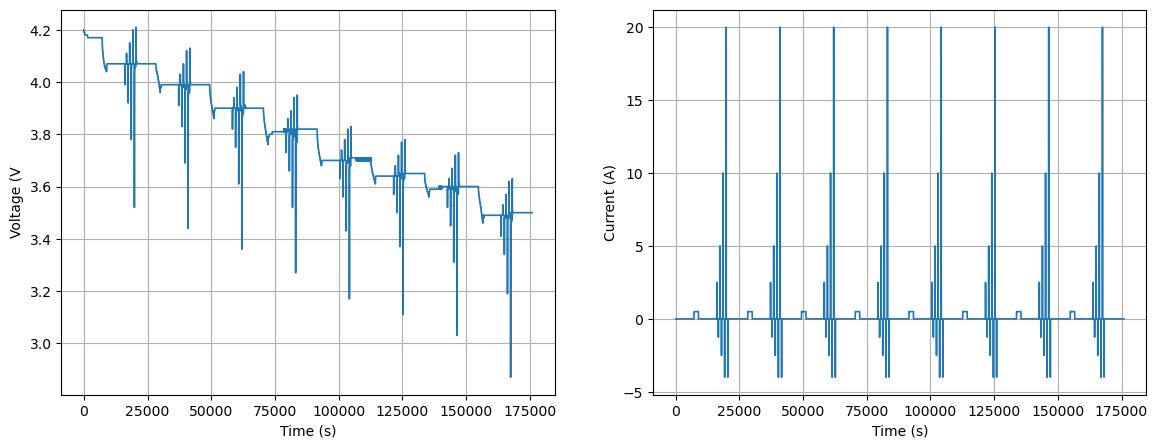

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(t, V_actual, linewidth=1.2)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Voltage (V')
axes[0].grid()

# _, ax = plt.subplots(figsize=(10, 6))
axes[1].plot(t, I, linewidth=1.2)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Current (A)')
axes[1].grid()

fig.savefig('Figures/Part 2/2a_training_data.eps', format='eps')
plt.show()

## Splitting pulses

In [35]:
# shift to left by one index (now i is equivalent to i+1)
I_shifted = np.concatenate((I[1:], [0]))
idx_pulse_start = np.flatnonzero((I == 0) & (np.abs(I_shifted) > 1))
idx_pulse_end = np.flatnonzero((np.abs(I) > 1) & (I_shifted == 0)) + 1

# reshape to 8 x 8 matrix, where rows correspond to each SOC value and
#                                cols correspond to each pulse with different current
idx_pulse_start = idx_pulse_start.reshape(8, 8)
idx_pulse_end = idx_pulse_end.reshape(8, 8)

to get the starting positions for all SOC values:

idx_pulse_start[:, 0]

## A bit visulisation (not part of the answer):

For each SOC value, we will have:

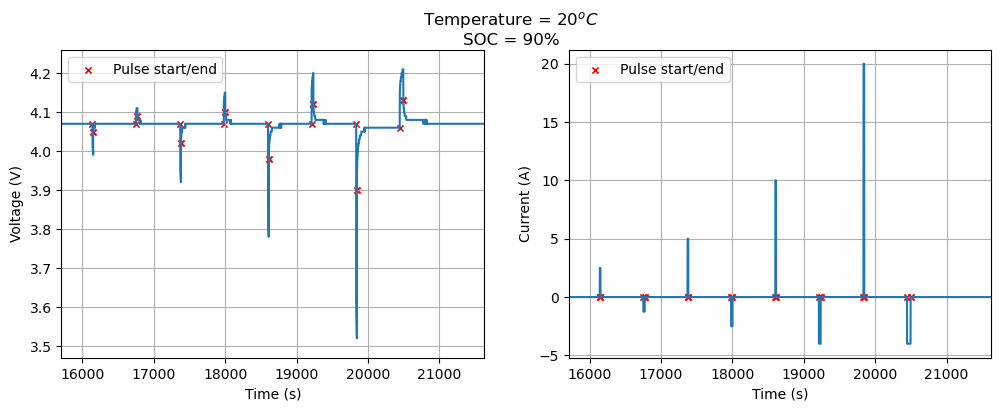

In [36]:
show_SOC = 1  # which_SOC_to_inspect
show_pulse = 'all'  # which_pulse_to_inspect
_ = plot_pulses(t, I, V_actual, idx_pulse_start, idx_pulse_end,
                show_SOC, show_pulse)

Further zoom in:

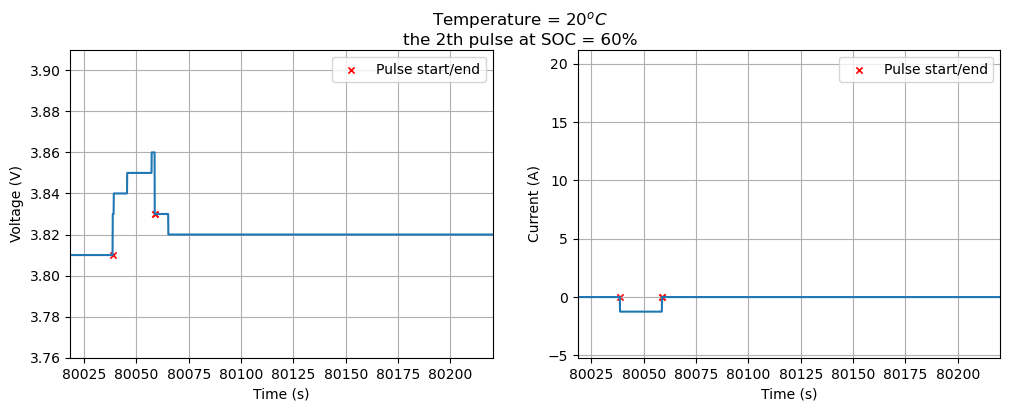

In [37]:
show_SOC = 4  # which_SOC_to_inspect
show_pulse = 2  # which_pulse_to_inspect
_ = plot_pulses(t, I, V_actual, idx_pulse_start, idx_pulse_end,
                show_SOC, show_pulse)

idx_pulse_start and idx_pulse_end identify the position where the current pulse start and finish. For the voltage, it needs some times to rest and recover to zero.

Therefore, to split the overall graph for different pulses, only idx_pulse_start is used. idx_pulse_end can be used to do parametrisation (see later).


### Find index of steady-state voltage for each pulse

In [38]:
idx_Vss = find_Vss_pos(t, V_actual, idx_pulse_start, idx_pulse_end)[0]

Plot the steady-state voltage of each pulse:

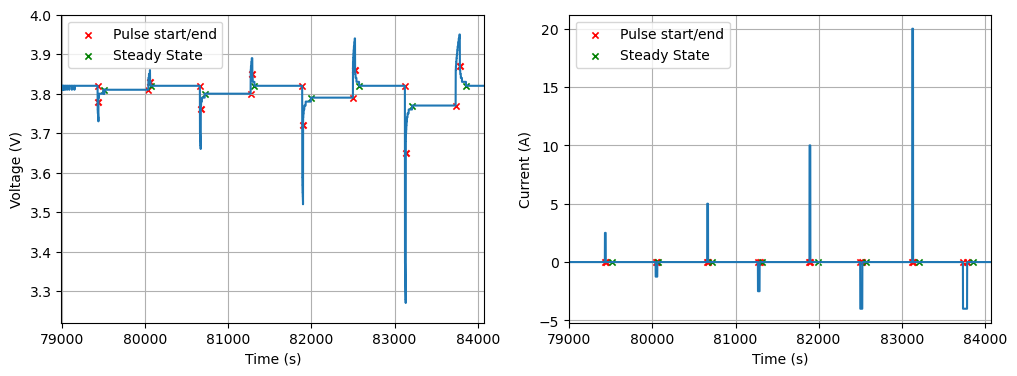

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


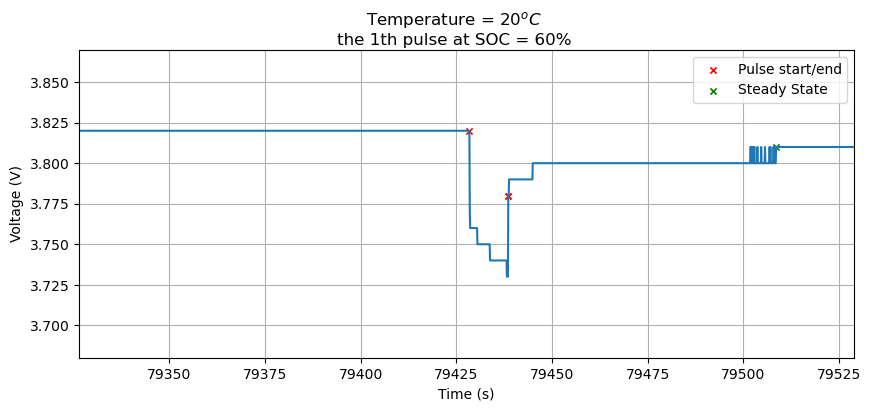

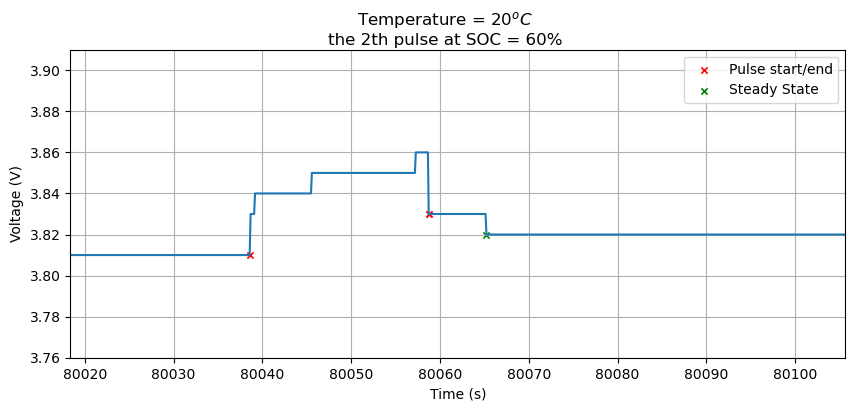

In [62]:
which_SOC = 4
which_pulse = 'all'
fig = plot_pulses(t, I, V_actual, idx_pulse_start, idx_pulse_end,
                  which_SOC, which_pulse, idx_Vss, show_current=True, show_title=False)
fig.savefig('Figures/Part 2/steady_state.eps', format='eps')

which_SOC = 4
which_pulse = 1
_ = plot_pulses(t, I, V_actual, idx_pulse_start, idx_pulse_end,
                which_SOC, which_pulse, idx_Vss, show_current=False)

which_SOC = 4
which_pulse = 2
_ = plot_pulses(t, I, V_actual, idx_pulse_start, idx_pulse_end,
                which_SOC, which_pulse, idx_Vss, show_current=False)

## Parametrisation

In [65]:
R0_tab, R1_tab, C1_tab, I_peaks, d_I, d_Vinf = para_RC(t, I, V_actual, idx_pulse_end, idx_Vss)

# Visualisation:
rows = pd.MultiIndex.from_product([['%d%%' % (SOC_from_idx_map[i]*100) for i in range(8)],
                                   np.arange(1, 9)],
                                   names=['SOC', 'Pulse'])

df = pd.DataFrame({'$R_0$ $(\Omega)$': R0_tab.flatten(),
                   '$R_1$ $(\Omega)$': R1_tab.flatten(),
                   '$C_1$ $(F)$': np.round(C1_tab, 1).flatten()}, index=rows)

# For display:
df1, df2 = np.array_split(df, 2, axis=0)
table1 = df1.to_html()
table2 = df2.to_html()

# Concatenate the HTML tables horizontally
html = '<table><tr><td>{0}</td><td>{1}</td></tr></table>'.format(table1, table2)

display(HTML(html))

### Step c

$R_0$ is nearly constant, thus remove the dependency

In [41]:
R0_const = np.mean(R0_tab)
R0_const

0.019554687500000018

### Step d

Do the same for $C_1$ as instructed, but why?

In [42]:
C1_const = np.mean(C1_tab)

with open(os.path.join(fit_res_dir, 'C1.json'), "w") as outfile:
    json.dump({'C1_const': C1_const}, outfile)
    
C1_const

1348.8167320601592

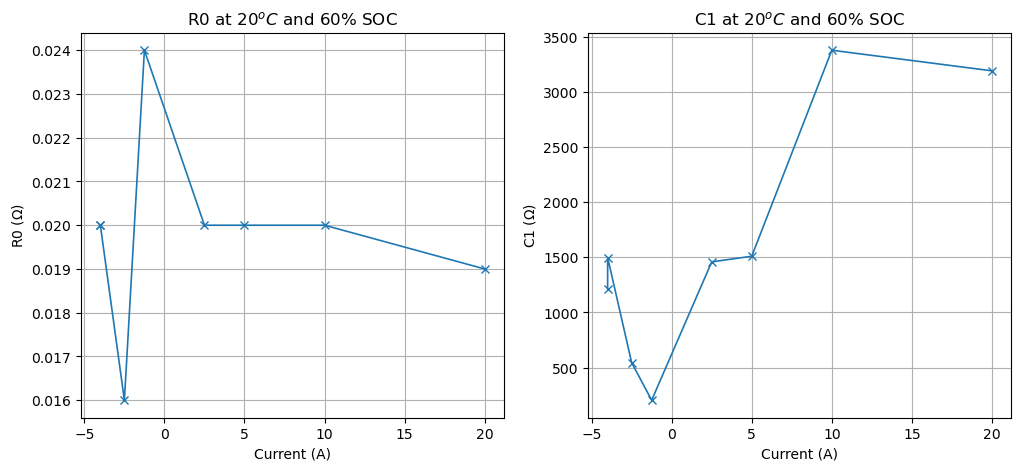

In [77]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))

sorted_idx_I = np.argsort(I_peaks[3, :])

ax1.plot(I_peaks[3, sorted_idx_I], R0_tab[3, sorted_idx_I], '-x', linewidth=1.2)
ax1.grid()
ax1.set_xlabel('Current (A)')
ax1.set_ylabel('R0 ($\Omega$)')
ax1.set_title('R0 at $20^oC$ and $60\%$ SOC')

ax2.plot(I_peaks[3, sorted_idx_I], C1_tab[3, sorted_idx_I], '-x', linewidth=1.2)
ax2.grid()
ax2.set_xlabel('Current (A)')
ax2.set_ylabel('C1 ($\Omega$)')
ax2.set_title('C1 at $20^oC$ and $60\%$ SOC')

fig.savefig('Figures/Part 2/2a_R0C1_20deg_60_SOC.eps', format='eps')
plt.show()

In [44]:
I_peaks

array([[ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ],
       [ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ],
       [ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ],
       [ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ],
       [ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ],
       [ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ],
       [ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ],
       [ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ]])

### Step e

Refit R1 using the constant R0 (and C1?)

In [75]:
R1_tab = np.abs(d_Vinf / d_I - R0_const)
# R1_tab = np.abs((t[idx_Vss] - t[idx_pulse_end]) / (4*C1_tab))

# Visualisation:
rows = pd.MultiIndex.from_product([['%d%%' % (SOC_from_idx_map[i]*100) for i in range(8)],
                                   np.arange(1, 9)],
                                   names=['SOC', 'Pulse'])

df = pd.DataFrame({'$R_1$ $(\Omega)$': np.round(R1_tab, 5).flatten()}, index=rows)

# For display:
df1, df2, df3, df4 = np.array_split(df, 4, axis=0)
table1 = df1.to_html()
table2 = df2.to_html()
table3 = df3.to_html()
table4 = df4.to_html()

# Concatenate the HTML tables horizontally
# html = '<table><tr><td>{0}</td><td>{1}</td></tr></table>'.format(table1, table2)
html = '<table><tr><td>{0}</td><td>{1}</td><td>{2}</td><td>{3}</td></tr></table>'.format(table1, table2, table3, table4)
display(HTML(html))

Let's see its dependency of SOC:

In [46]:
SOC_at_Vss = [round(match_val(vss, ref_OCV, ref_SOC), 1) for vss in V_actual[idx_Vss].flatten()]
print('SOC after at each V_ss:\n')
print(np.reshape(SOC_at_Vss, [8, 8]))

SOC after at each V_ss:

[[89.6 89.6 89.6 89.6 87.2 92.4 87.2 92.4]
 [79.9 80.7 79.9 80.7 79.  81.5 78.2 81.5]
 [71.7 71.7 70.3 73.  69.1 73.  67.9 73. ]
 [62.  62.9 61.2 62.9 60.5 62.9 58.9 62.9]
 [51.7 51.7 51.7 52.9 50.4 52.9 49.  52.9]
 [42.3 44.2 42.3 44.2 40.3 44.2 38.2 44.2]
 [32.7 34.4 32.7 34.4 31.3 34.4 30.1 36.2]
 [22.7 22.7 22.  23.4 22.  23.4 20.7 23.4]]


### Step f

plot R1 for $20^oC$ and $60\%$ SOC against current

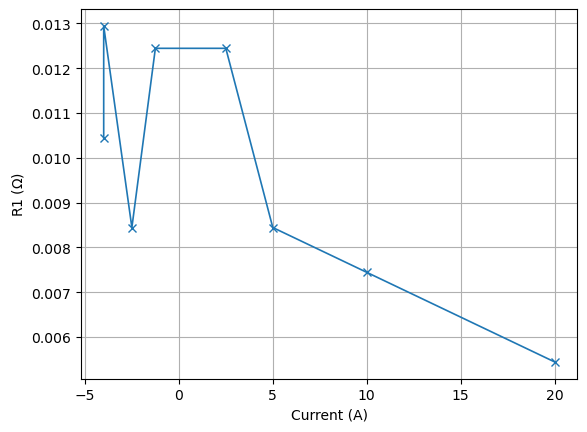

In [80]:
sorted_idx_I = np.argsort(I_peaks[3, :])
fig, ax = plt.subplots()
ax.plot(I_peaks[3, sorted_idx_I], R1_tab[3, sorted_idx_I], '-x', linewidth=1.2)
ax.grid()
ax.set_xlabel('Current (A)')
ax.set_ylabel('R1 ($\Omega$)')
# ax.set_title('R1 at $20^oC$ and $60\%$ SOC')
plt.show()
fig.savefig('Figures/Part 2/2a_R1_20deg_60_SOC.eps', format='eps')

##### Now we have R0, R1, C1 as functions of SOC and current, but we only have limited points. For example, if we need R1 at 84 % SOC, we need to linear-interpolate it.

### R1 look-up table

For simplicity, just use 90% - 20% with an interval of 10% for R1 look-up table.

It looks like at the beginning there are two current of -4A, which will raise error for interpolation. It is also weird that for the same current and SOC, the R1 are different. For now, remove the last column for look-up table for simplicity (assumption made).

In [48]:
# interp2d takes input arrays in ascending order
sorted_idx_col = np.argsort(I_peaks[0])
R1_look_up_tab = R1_tab[:, sorted_idx_col]
I_tab = I_peaks[0, sorted_idx_col]

sorted_idx_row = np.argsort(SOC_levels)
R1_look_up_tab = R1_look_up_tab[sorted_idx_row, :]
SOC_tab = SOC_levels[sorted_idx_row]

print(I_tab)
print(SOC_tab)
print(np.round(R1_look_up_tab, 5))

# remove the last column
I_tab = I_tab[1:]
R1_look_up_tab = R1_look_up_tab[:, 1:]

R1_interp_func = interp2d(I_tab, SOC_tab, R1_look_up_tab)

[-4.   -4.   -2.5  -1.25  2.5   5.   10.   20.  ]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[[0.01045 0.01295 0.00845 0.01245 0.01245 0.00845 0.00945 0.01045]
 [0.01045 0.01045 0.00845 0.00445 0.00845 0.00845 0.00745 0.00745]
 [0.01045 0.01045 0.00845 0.00445 0.00845 0.00845 0.00645 0.00595]
 [0.00795 0.01045 0.00845 0.01245 0.00845 0.00845 0.00645 0.00595]
 [0.01045 0.01295 0.00845 0.01245 0.01245 0.00845 0.00745 0.00545]
 [0.01045 0.01295 0.00845 0.01245 0.01245 0.00845 0.00745 0.00595]
 [0.01045 0.01295 0.01245 0.01245 0.00845 0.01045 0.00845 0.00645]
 [0.01045 0.01295 0.01245 0.01245 0.01245 0.01045 0.00845 0.00745]]


In [49]:
test_I = -6
test_SOC = 0.3

interp_value = R1_interp_func(test_I, test_SOC)

print('Test interpolated value:', interp_value)

Test interpolated value: [0.01044531]


## Fit 1st order ECN model (R1 from look-up table)

## !!!!!

Define the placeholder functions for fitting R0, R1, C1. These functions will be the inputs of the first order ECN model. 
For now, R0 and C1 are constants. Change these three functions as the model updating. 

These three functions are created to ensure the function of fitting ECN model can be used everywhere throughout this project. The 
only thing to do is to change these three functions.

In [50]:
def fit_R0(I=None, z=None, T=None):
    R0_val = R0_const
    return R0_val


## only R1 depends on I and z
def fit_R1(I, z, T=None):
    R1_val = R1_interp_func(I, z)[0]  # from the look-up table built before
    # print(R1_val)
    return R1_val


def fit_C1(I=None, z=None, T=None):
    C1_val = C1_const
    return C1_val

In [51]:
T = None  # for now, no dependency on temperature

# Select which pulse to fit into the first order ECN model
which_SOC = 1
which_pulse = 4
t_seg, I_seg, V_actual_seg = select_pulse(t, I, V_actual, idx_pulse_start, idx_Vss, 
                                          which_SOC, which_pulse, pad_zero=True)

V_pred = first_order_ECN(t_seg, I_seg, T, V_actual_seg, ref_OCV, ref_SOC,
                         fit_R0, fit_R1, fit_C1)

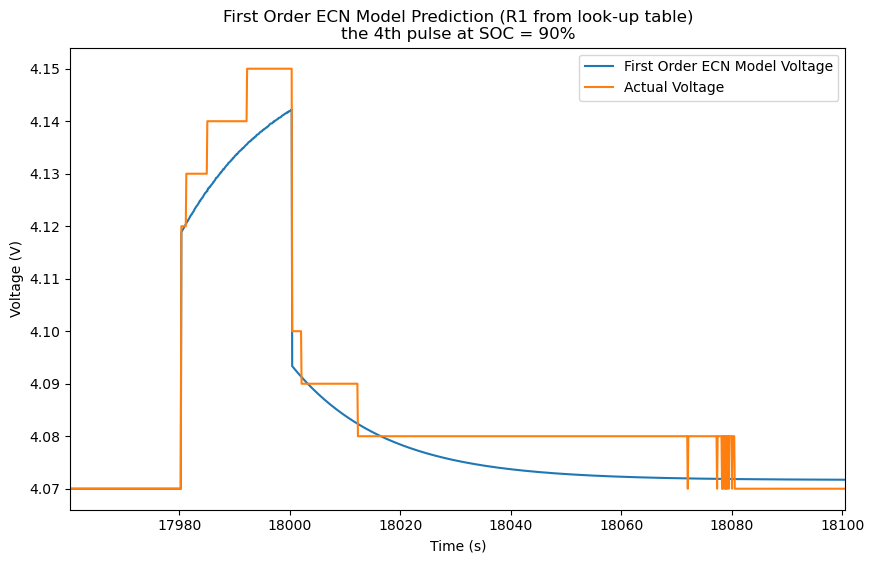

In [52]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_seg, V_pred, label='First Order ECN Model Voltage')
ax.plot(t_seg, V_actual_seg, label='Actual Voltage')
ax.legend()
ax.set_xlim([t_seg[0], t_seg[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
pulse_info = 'the {}th pulse at SOC = {:0.0f}%'.format(which_pulse,
                                      SOC_from_idx_map[which_SOC-1]*100)
ax.set_title('First Order ECN Model Prediction (R1 from look-up table)\n'+pulse_info)
plt.show()

### Step g

Fit R1 for $20^oC$ and $60\%$ SOC to a first order Gaussian function as a function of current

In [53]:
R1_0A = R1_interp_func(0, 0.6)[0]

print('R^{0A}_1 = ', R1_0A)

R^{0A}_1 =  0.012445312500000007


Get the small bumps before each 8 pulses start, and obtain the R1 values, so that there will be a small R1 value around 0 for better fitting Gaussian.

In [54]:
I_shifted = np.concatenate((I[1:], [0]))
idx_bump_start = np.flatnonzero((I == 0) & (np.abs(I_shifted) < 1) & (np.abs(I_shifted) > 0.2))
idx_bump_end = np.flatnonzero((np.abs(I) < 1) & (np.abs(I) > 0.2) & (I_shifted == 0)) + 1

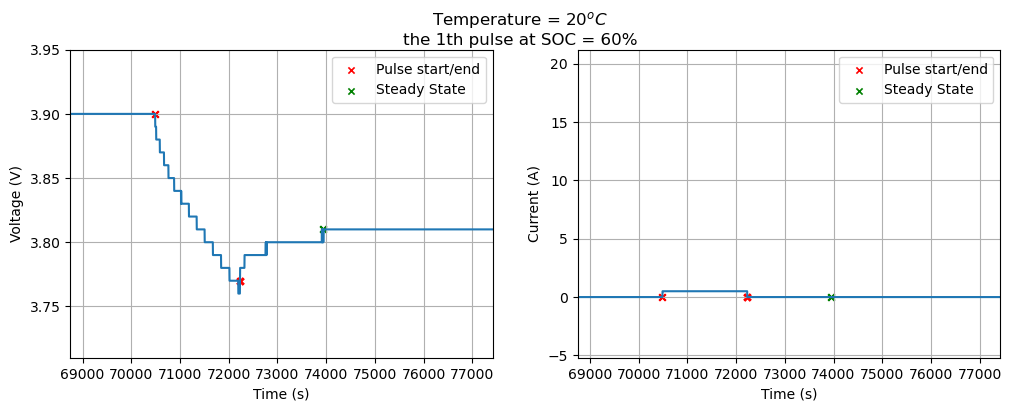

In [55]:
idx_bump_Vss = find_Vss_pos(t, V_actual, idx_bump_start, idx_bump_end, 
                            for_bump=True, idx_for_bump=idx_pulse_start)[0]

show_SOC = 4
show_pulse = 1
_ = plot_pulses(t, I, V_actual, np.repeat(idx_bump_start.reshape(-1, 1), 8, axis=1), 
                np.repeat(idx_bump_end.reshape(-1, 1), 8, axis=1),
                show_SOC, show_pulse, np.repeat(idx_bump_Vss.reshape(-1, 1), 8, axis=1))

Parametrisation on the bump:

In [56]:
_, R1_bumps, _, I_bumps, d_I_bumps, d_Vinf_bumps = para_RC(t, I, V_actual, idx_bump_end, idx_bump_Vss)
R1_bumps = np.abs(d_Vinf_bumps / d_I_bumps - R0_const)
print(R1_bumps[3])
print(I_bumps[3])

0.08064571330160372
0.499


add the bump values for fitting

In [57]:
I_fit = np.concatenate((I_peaks[3, :], [I_bumps[3]]))
R1_true = np.concatenate((R1_tab[3, :], [R1_bumps[3]]))

sorted_idx_I = np.argsort(I_fit)
I_fit = I_fit[sorted_idx_I]
R1_true = R1_true[sorted_idx_I]

print(R1_true)

[0.01044531 0.01294531 0.00844531 0.01244531 0.08064571 0.01244531
 0.00844531 0.00744531 0.00544531]


Fitted parameters:
R1_0A = 0.08111564578969978
b = 0.6143108570411192
c = 1.9108672279136518


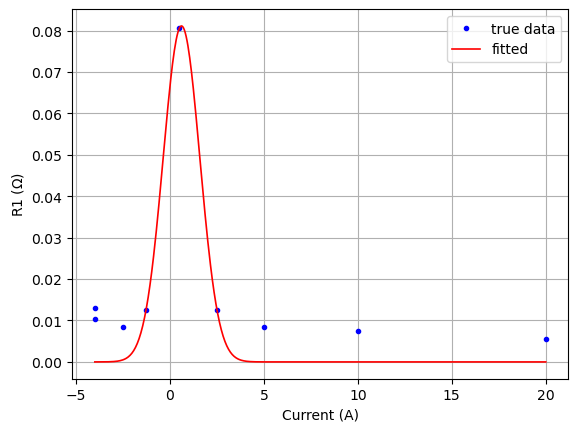

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [82]:
# Define the Gaussian function
def gaussian(I_fit, R1_0A, b, c):
    return R1_0A * np.exp(-(I_fit - b)**2 / c)

# x = np.delete(I_fit, 1)  # delete outlier
# y_true = np.delete(R1_true, 1)
x = I_fit
y_true = R1_true
my_func = gaussian

p0 = [R1_0A, 0, 100]
popts, x_plot, y_pred = fit_RC(x, y_true, my_func, p0)

# Print the fitted parameters
print('Fitted parameters:')
print('R1_0A =', popts[0])
print('b =', popts[1])
print('c =', popts[2])

# Plot the data and the fitted function
fig, ax = plt.subplots()
ax.plot(I_fit, R1_true, 'b.', label='true data', linewidth=1.2)
ax.plot(x_plot, y_pred, 'r-', label='fitted', linewidth=1.2)
ax.legend()
ax.grid()
ax.set_xlabel('Current (A)')
ax.set_ylabel('R1 ($\Omega$)')
# ax.set_title('First Order Gaussian Function fitted on R1 at $60\%$ SOC and $20^oC$')
plt.show()
fig.savefig('Figures/Part 2/2a_equation1_fitting_wo_offset.eps', format='eps')

### Step h

Improve the Gaussian function.

Looks like it needs an offset. Assume it is current dependent has a transient behaviour (or not).

Fitted parameters:
R1_0A = 0.07277115854930268
b = 0.6251583740721869
c = 1.1674824537895128
d = 0.008860072026879086
[0.07277116 0.62515837 1.16748245 0.00886007]


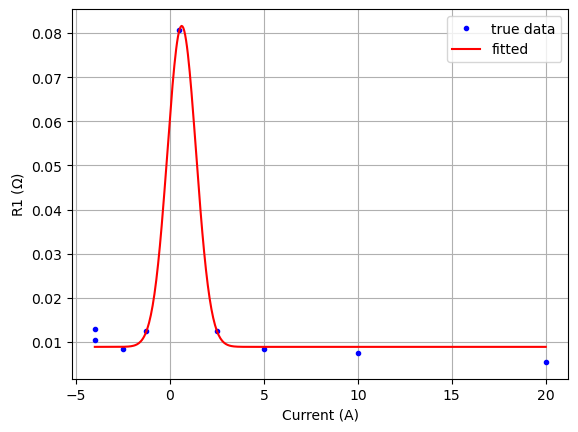

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [84]:
# Define the Gaussian function
def gaussian(I_fit, R1_0A, b, c, d):
    return R1_0A * np.exp(-(I_fit - b)**2 / c)  + d
#     return R1_0A * np.exp(-(I_fit - b)**2 / c) + d1 * np.exp(-(I_fit)/d2)

# x = np.delete(I_fit, 1)  # delete outlier
# y_true = np.delete(R1_true, 1)
x = I_fit
y_true = R1_true
my_func = gaussian

def fit_RC(x, y_true, func, p0=None):
    """
    For part 2
    Now only usable for one indepenent variable
    """
    popts, _ = curve_fit(func, x, y_true, p0)

    x_plot = np.linspace(np.min(x), np.max(x), 500)
#     popts[2] = 200
    y_pred = func(x_plot, *popts)
    
    return popts, x_plot, y_pred

p0 = [R1_0A_guess, b_guess, c_guess, 0.005, 0, 0]
popts, x_plot, y_pred = fit_RC(x, y_true, my_func)

# Print the fitted parameters
print('Fitted parameters:')
print('R1_0A =', popts[0])
print('b =', popts[1])
print('c =', popts[2])
print('d =', popts[3])
print(popts)

# Plot the data and the fitted function
fig, ax = plt.subplots()
ax.plot(I_fit, R1_true, 'b.', label='true data', linewidth=1.2)
ax.plot(x_plot, y_pred, 'r-', label='fitted', linewidth=1.2)
ax.grid()
ax.legend()
ax.set_xlabel('Current (A)')
ax.set_ylabel('R1 ($\Omega$)')
# ax.set_title('First Order Gaussian Function fitted on R1 at $60\%$ SOC and $20^oC$')
plt.show()

fig.savefig('Figures/Part 2/2a_equation1_fitting_with_offset.eps', format='eps')

In [60]:
# info = {'R1_0A': popts[0],
#         'b': popts[1],
#         'c': popts[2],
#         'd': popts[3]}

# with open(os.path.join(fit_res_dir, 'R1_gauss.json'), "w") as outfile:
#     json.dump(info, outfile)